cuda:0


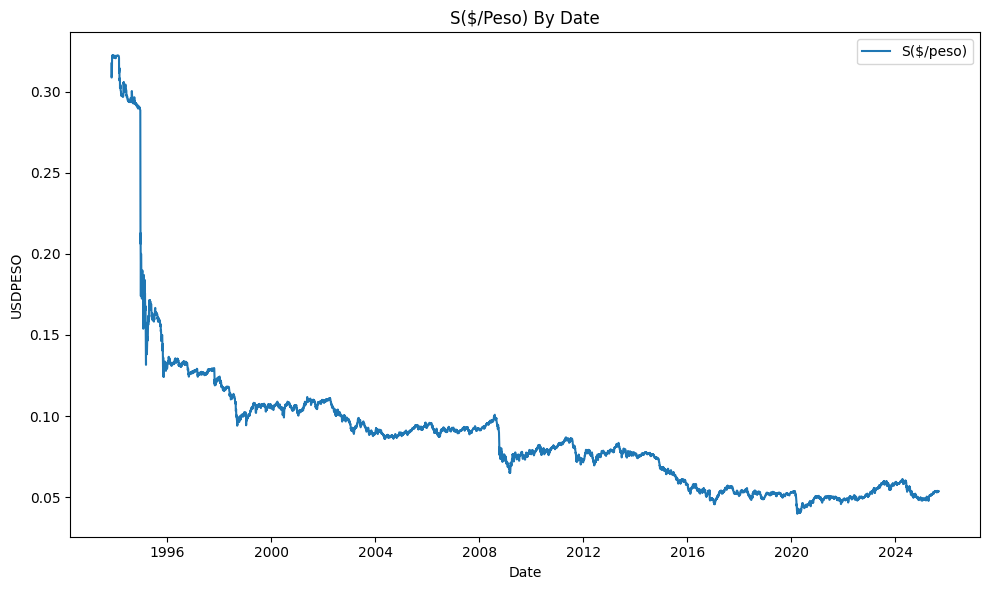

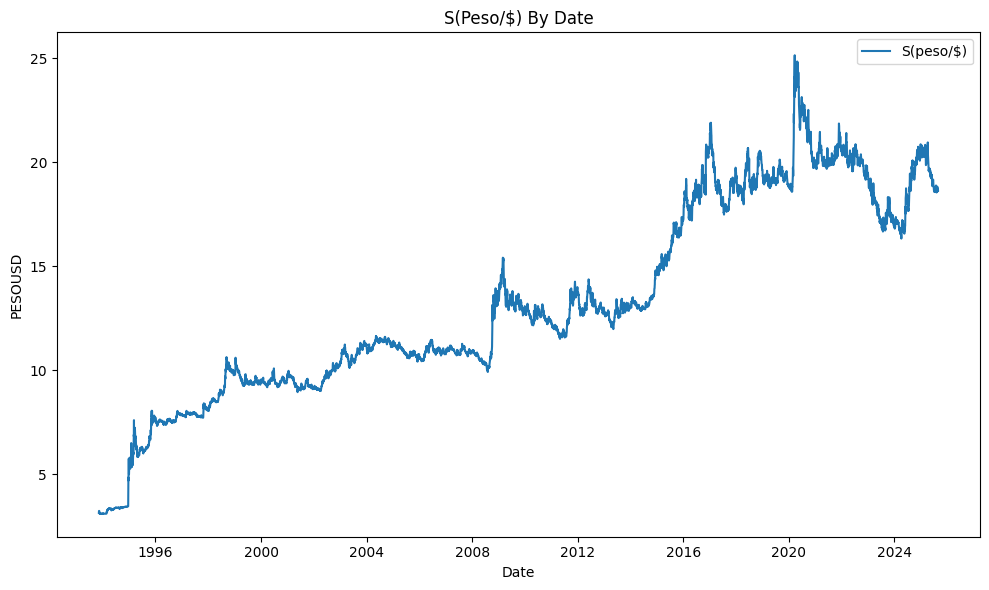

In [1]:
import fredapi as fr
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
import mlflow
import mlflow.pytorch
from sklearn.metrics import r2_score,root_mean_squared_error,mean_absolute_percentage_error
from dotenv import load_dotenv
import os
load_dotenv()

fred_api_key = os.getenv("FRED_API_KEY")

device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)


fred = fr.Fred(fred_api_key)




pesousd = fred.get_series("DEXMXUS")
pesousd.name = "PESOUSD"

df = pd.concat([pesousd],axis=1).dropna()
df = df.reset_index()
df['Date'] = df['index']
df.drop('index',axis=1,inplace=True)

df['USDPESO']  = 1 / df['PESOUSD']


plt.figure(figsize=(10,6))
sns.lineplot(x='Date',y='USDPESO',data=df,label="S($/peso)")
plt.title("S($/Peso) By Date")
plt.savefig("images/spotrate-USD-PESO.png")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,6))
sns.lineplot(x='Date',y='PESOUSD',data=df,label="S(peso/$)")
plt.title("S(Peso/$) By Date")
plt.savefig("images/spotrate-PESO-USD.png")
plt.tight_layout()
plt.show()

In [2]:
A = np.array([[df['USDPESO'][1],df['PESOUSD'][1]],[df['PESOUSD'][1],df['USDPESO'][1]]])
print(f'1:1 Ratio of Currency Pairs: {A}')

1:1 Ratio of Currency Pairs: [[0.30864198 3.24      ]
 [3.24       0.30864198]]


In [3]:
df.drop('PESOUSD',inplace=True,axis=1)
df.drop_duplicates(inplace=True)


In [4]:
# training


training = df.iloc[:,1:2].values



train_size = int(len(training) * .80)


train_data = training[:train_size]
test_data = training[train_size:]


scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)



def slider(dataframe,seq_length):
    X,y = [],[]
    for i in range(len(dataframe) - seq_length):
        Xi = dataframe[i:(i+seq_length)]
        yi = dataframe[(i+seq_length)]
        X.append(Xi)
        y.append(yi)
        
    return np.array(X),np.array(y)

seq_length = 1

X_train,y_train = slider(train_scaled,seq_length)
X_test,y_test = slider(test_scaled,seq_length)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()






class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GRU, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, X):
        h0 = torch.zeros(1, X.size(0), self.hidden_size)
        out, _ = self.gru(X, h0)
        out = self.fc(out[:,-1,:])
        return out


input_size = 1
hidden_size = 256
num_layers = 1
output_size = 1

gru_model = GRU(input_size,hidden_size,num_layers,output_size)
epochs = 500
learning_rate = 0.001
optimizer_gru = torch.optim.Adam(params=gru_model.parameters(),lr=learning_rate)
loss_fn = nn.MSELoss()


In [5]:
with mlflow.start_run() as run:

    mlflow.log_params({
        "input_size": input_size,
        "hidden_size": hidden_size,
        "num_layers": num_layers,
        "output_size": output_size,
        "epochs": epochs,
        "learning_rate": learning_rate,
        "optimizer": optimizer_gru.__class__.__name__,
        "loss_function": loss_fn.__class__.__name__
    }) 

    for epoch in range(epochs):
        y_pred = gru_model(X_train)
        loss = loss_fn(y_pred.float(), y_train)
        optimizer_gru.zero_grad()
        loss.backward()
        optimizer_gru.step()

        if epoch % 1 != 0:
            continue

        gru_model.eval()
        with torch.no_grad():
            y_pred_train = gru_model(X_train)
            train_rsme = np.sqrt(loss_fn(y_pred_train, y_train))
            y_pred_test = gru_model(X_test)
            test_rsme = np.sqrt(loss_fn(y_pred_test, y_test))
            print(f'Epoch: {epoch}; train_RSEM: {train_rsme:.4}; Test RSME: {test_rsme:.4}')

         
            mlflow.log_metric("train_rsme", train_rsme, step=epoch) 
            mlflow.log_metric("test_rsme", test_rsme, step=epoch) 


    mlflow.pytorch.log_model(pytorch_model=gru_model, artifact_path="gru_model")

/tmp/ipykernel_113775/237286656.py:27: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  train_rsme = np.sqrt(loss_fn(y_pred_train, y_train))
/tmp/ipykernel_113775/237286656.py:29: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  test_rsme = np.sqrt(loss_fn(y_pred_test, y_test))


Epoch: 0; train_RSEM: 0.2158; Test RSME: 0.05539
Epoch: 1; train_RSEM: 0.2085; Test RSME: 0.06652
Epoch: 2; train_RSEM: 0.2016; Test RSME: 0.07771
Epoch: 3; train_RSEM: 0.1953; Test RSME: 0.0889
Epoch: 4; train_RSEM: 0.1896; Test RSME: 0.1
Epoch: 5; train_RSEM: 0.1846; Test RSME: 0.1111
Epoch: 6; train_RSEM: 0.1802; Test RSME: 0.1219
Epoch: 7; train_RSEM: 0.1766; Test RSME: 0.1324
Epoch: 8; train_RSEM: 0.1737; Test RSME: 0.1426
Epoch: 9; train_RSEM: 0.1715; Test RSME: 0.1522
Epoch: 10; train_RSEM: 0.1699; Test RSME: 0.1612
Epoch: 11; train_RSEM: 0.1688; Test RSME: 0.1693
Epoch: 12; train_RSEM: 0.1682; Test RSME: 0.1765
Epoch: 13; train_RSEM: 0.1678; Test RSME: 0.1826
Epoch: 14; train_RSEM: 0.1675; Test RSME: 0.1874
Epoch: 15; train_RSEM: 0.1671; Test RSME: 0.191
Epoch: 16; train_RSEM: 0.1667; Test RSME: 0.1933
Epoch: 17; train_RSEM: 0.166; Test RSME: 0.1944
Epoch: 18; train_RSEM: 0.1651; Test RSME: 0.1943
Epoch: 19; train_RSEM: 0.164; Test RSME: 0.1932
Epoch: 20; train_RSEM: 0.1627; Te

2025/09/04 15:08:30 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch: 498; train_RSEM: 0.005127; Test RSME: 0.00311
Epoch: 499; train_RSEM: 0.005127; Test RSME: 0.003108


2025/09/04 15:08:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Mean Absolute Percentage Error: 0.3161
R2 Score: 95.66%
Root Mean Squared Error: 0.003108


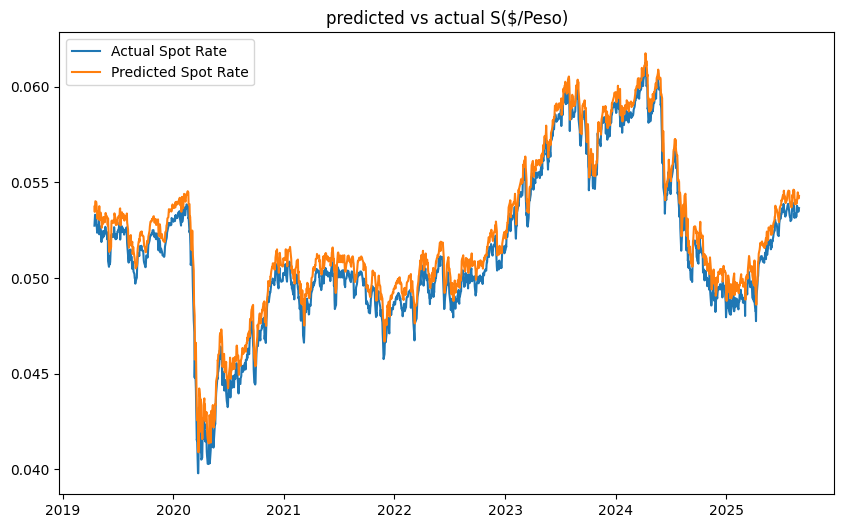

In [8]:
with torch.no_grad():
    pred = gru_model(X_test)
    pred_np = pred.cpu().numpy()
    y_test_np = y_test.cpu().numpy()
    pred_rescaled = scaler.inverse_transform(pred_np)
    actual_rescaled = scaler.inverse_transform(y_test_np)



test_dates = df.iloc[train_size + seq_length:]['Date']


gru_comparison_df = pd.DataFrame({
    "Date": test_dates,
    "Actual Spot Rate": actual_rescaled.flatten(),
    "Predicted Spot Rate": pred_rescaled.flatten()
})


# MAPE
mape = mean_absolute_percentage_error(y_test_np,pred_np)
print(f'Mean Absolute Percentage Error: {mape:.4f}')

#r2 score
r2 = r2_score(y_test_np,pred_np)
print(f'R2 Score: {r2*100:.2f}%')

#Root Mean Squared Error

rmse = root_mean_squared_error(y_test_np,pred_np)
print(f'Root Mean Squared Error: {rmse:.4}')



plt.figure(figsize=(10,6))
plt.plot(gru_comparison_df['Date'],gru_comparison_df["Actual Spot Rate"],label="Actual Spot Rate")
plt.plot(gru_comparison_df['Date'],gru_comparison_df['Predicted Spot Rate'],label="Predicted Spot Rate")
plt.title("predicted vs actual S($/Peso)")
plt.legend()
plt.savefig("images/predicted_vs_actual_SpotRate_gru-usd-peso.png")
plt.show()


In [9]:


print(np.round(gru_comparison_df,4).head(20))
print(np.round(gru_comparison_df,4).tail(20))

           Date  Actual Spot Rate  Predicted Spot Rate
6381 2019-04-16            0.0527               0.0537
6382 2019-04-17            0.0531               0.0535
6383 2019-04-18            0.0533               0.0538
6384 2019-04-19            0.0533               0.0540
6385 2019-04-22            0.0531               0.0540
6386 2019-04-23            0.0528               0.0538
6387 2019-04-24            0.0526               0.0535
6388 2019-04-25            0.0524               0.0533
6389 2019-04-26            0.0528               0.0531
6390 2019-04-29            0.0526               0.0535
6391 2019-04-30            0.0526               0.0533
6392 2019-05-01            0.0530               0.0534
6393 2019-05-02            0.0523               0.0538
6394 2019-05-03            0.0527               0.0530
6395 2019-05-06            0.0527               0.0534
6396 2019-05-07            0.0525               0.0534
6397 2019-05-08            0.0524               0.0532
6398 2019-